In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.lstm = nn.LSTM(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        lstm_out, hidden = self.lstm(x, hidden)
        last_output = lstm_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 5000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # LSTM hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 5000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 3941
Total number of data samples in valid_loader: 1313
Total number of data samples in test_loader: 1314


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = LSTM(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [24]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/5000_LSTM') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 6/6 [00:00<00:00, 375.20it/s]


Model saved
TRAIN LOSS = 0.0025267834985235023, TRAIN ACC = 0.7579294595280386, 
VALID LOSS = 0.002724591730572482, VALID ACC = 0.7692307692307693, 
epoch 2


100%|██████████| 6/6 [00:00<00:00, 379.01it/s]


TRAIN LOSS = 0.002228744371504204, TRAIN ACC = 0.7597056584623192, 
VALID LOSS = 0.0023467610423472305, VALID ACC = 0.7692307692307693, 
epoch 3


100%|██████████| 6/6 [00:00<00:00, 322.87it/s]


TRAIN LOSS = 0.001980984431781977, TRAIN ACC = 0.7597056584623192, 
VALID LOSS = 0.001954489188256013, VALID ACC = 0.7692307692307693, 
epoch 4


100%|██████████| 6/6 [00:00<00:00, 333.69it/s]


TRAIN LOSS = 0.0018796331157723044, TRAIN ACC = 0.7589444303476275, 
VALID LOSS = 0.002089688615406731, VALID ACC = 0.7692307692307693, 
epoch 5


100%|██████████| 6/6 [00:00<00:00, 484.00it/s]


TRAIN LOSS = 0.001849914680002789, TRAIN ACC = 0.7597056584623192, 
VALID LOSS = 0.0019611615037881773, VALID ACC = 0.7692307692307693, 
epoch 6


100%|██████████| 6/6 [00:00<00:00, 245.92it/s]


TRAIN LOSS = 0.0017659206418814439, TRAIN ACC = 0.7597056584623192, 
VALID LOSS = 0.001919963572284963, VALID ACC = 0.7692307692307693, 
epoch 7


100%|██████████| 6/6 [00:00<00:00, 405.34it/s]


TRAIN LOSS = 0.0017417027347736993, TRAIN ACC = 0.7597056584623192, 
VALID LOSS = 0.0018666125351658144, VALID ACC = 0.7692307692307693, 
epoch 8


100%|██████████| 6/6 [00:00<00:00, 464.87it/s]


TRAIN LOSS = 0.0016725470997965963, TRAIN ACC = 0.7597056584623192, 
VALID LOSS = 0.0018498494892018676, VALID ACC = 0.7692307692307693, 
epoch 9


100%|██████████| 6/6 [00:00<00:00, 330.75it/s]


TRAIN LOSS = 0.0016100287845793547, TRAIN ACC = 0.759451915757422, 
VALID LOSS = 0.0016231647857889726, VALID ACC = 0.7692307692307693, 
epoch 10


100%|██████████| 6/6 [00:00<00:00, 405.57it/s]


TRAIN LOSS = 0.0015416041496773415, TRAIN ACC = 0.7607206292819082, 
VALID LOSS = 0.0016932473188125715, VALID ACC = 0.7692307692307693, 
epoch 11


100%|██████████| 6/6 [00:00<00:00, 368.71it/s]


Model saved
TRAIN LOSS = 0.0014633564772384476, TRAIN ACC = 0.7619893428063943, 
VALID LOSS = 0.001933226876829021, VALID ACC = 0.7776085300837776, 
epoch 12


100%|██████████| 6/6 [00:00<00:00, 380.63it/s]


TRAIN LOSS = 0.0015470756700395236, TRAIN ACC = 0.7622430855112915, 
VALID LOSS = 0.0016365547445287073, VALID ACC = 0.7722772277227723, 
epoch 13


100%|██████████| 6/6 [00:00<00:00, 457.44it/s]


TRAIN LOSS = 0.001506234918321882, TRAIN ACC = 0.7685866531337224, 
VALID LOSS = 0.001712603688875592, VALID ACC = 0.7707539984767707, 
epoch 14


100%|██████████| 6/6 [00:00<00:00, 427.28it/s]


TRAIN LOSS = 0.00148341608694803, TRAIN ACC = 0.7721390510022836, 
VALID LOSS = 0.0016633495745183126, VALID ACC = 0.7753236862147753, 
epoch 15


100%|██████████| 6/6 [00:00<00:00, 382.67it/s]


Model saved
TRAIN LOSS = 0.0015290260723295989, TRAIN ACC = 0.7754377061659478, 
VALID LOSS = 0.001806006096558814, VALID ACC = 0.7783701447067783, 
epoch 16


100%|██████████| 6/6 [00:00<00:00, 435.46it/s]


Model saved
TRAIN LOSS = 0.001423192482495544, TRAIN ACC = 0.7769601623953312, 
VALID LOSS = 0.0015194168866180047, VALID ACC = 0.7829398324447829, 
epoch 17


100%|██████████| 6/6 [00:00<00:00, 391.70it/s]


TRAIN LOSS = 0.001431692617552379, TRAIN ACC = 0.7812737883785841, 
VALID LOSS = 0.0016583275540766604, VALID ACC = 0.7806549885757806, 
epoch 18


100%|██████████| 6/6 [00:00<00:00, 382.82it/s]


TRAIN LOSS = 0.0014841212321283612, TRAIN ACC = 0.7701091093631058, 
VALID LOSS = 0.0017026253583680012, VALID ACC = 0.776085300837776, 
epoch 19


100%|██████████| 6/6 [00:00<00:00, 403.96it/s]


Model saved
TRAIN LOSS = 0.001402497548677086, TRAIN ACC = 0.780005074854098, 
VALID LOSS = 0.0015554532056897084, VALID ACC = 0.7867479055597868, 
epoch 20


100%|██████████| 6/6 [00:00<00:00, 450.00it/s]


Model saved
TRAIN LOSS = 0.001335369912206567, TRAIN ACC = 0.7843187008373509, 
VALID LOSS = 0.0015100582764517325, VALID ACC = 0.789032749428789, 
epoch 21


100%|██████████| 6/6 [00:00<00:00, 426.68it/s]


TRAIN LOSS = 0.0012421389350247426, TRAIN ACC = 0.7848261862471454, 
VALID LOSS = 0.0015583483435593756, VALID ACC = 0.7844630616907845, 
epoch 22


100%|██████████| 6/6 [00:00<00:00, 300.50it/s]


TRAIN LOSS = 0.0012530965630822423, TRAIN ACC = 0.7888860695255011, 
VALID LOSS = 0.0015191082180862833, VALID ACC = 0.7852246763137852, 
epoch 23


100%|██████████| 6/6 [00:00<00:00, 397.08it/s]


Model saved
TRAIN LOSS = 0.001189182578867022, TRAIN ACC = 0.8282161887845725, 
VALID LOSS = 0.001630826025452218, VALID ACC = 0.8263518659558263, 
epoch 24


100%|██████████| 6/6 [00:00<00:00, 388.53it/s]


Model saved
TRAIN LOSS = 0.001248901056263296, TRAIN ACC = 0.8480081197665567, 
VALID LOSS = 0.001379691297011074, VALID ACC = 0.8446306169078446, 
epoch 25


100%|██████████| 6/6 [00:00<00:00, 485.39it/s]


TRAIN LOSS = 0.0011368340887535772, TRAIN ACC = 0.8553666582085765, 
VALID LOSS = 0.001378022616634093, VALID ACC = 0.8415841584158416, 
epoch 26


100%|██████████| 6/6 [00:00<00:00, 389.26it/s]


TRAIN LOSS = 0.0011060986648020906, TRAIN ACC = 0.8540979446840903, 
VALID LOSS = 0.0013588460138165487, VALID ACC = 0.8408225437928408, 
epoch 27


100%|██████████| 6/6 [00:00<00:00, 188.76it/s]


Model saved
TRAIN LOSS = 0.0010140365837068613, TRAIN ACC = 0.8678000507485409, 
VALID LOSS = 0.0012368237413891562, VALID ACC = 0.8591012947448591, 
epoch 28


100%|██████████| 6/6 [00:00<00:00, 406.84it/s]


TRAIN LOSS = 0.0009972359725165204, TRAIN ACC = 0.8807409286982999, 
VALID LOSS = 0.0012613484538064508, VALID ACC = 0.8575780654988576, 
epoch 29


100%|██████████| 6/6 [00:00<00:00, 425.27it/s]


TRAIN LOSS = 0.0009123353040390769, TRAIN ACC = 0.8822633849276833, 
VALID LOSS = 0.0012461492353418994, VALID ACC = 0.8545316070068545, 
epoch 30


100%|██████████| 6/6 [00:00<00:00, 412.64it/s]


TRAIN LOSS = 0.0009540508760470662, TRAIN ACC = 0.8756660746003553, 
VALID LOSS = 0.001469124480230792, VALID ACC = 0.8484386900228484, 
epoch 31


100%|██████████| 6/6 [00:00<00:00, 406.28it/s]


TRAIN LOSS = 0.001017491357999839, TRAIN ACC = 0.8713524486171023, 
VALID LOSS = 0.001518246810670491, VALID ACC = 0.8484386900228484, 
epoch 32


100%|██████████| 6/6 [00:00<00:00, 403.85it/s]


Model saved
TRAIN LOSS = 0.0009652806989011109, TRAIN ACC = 0.8802334432885055, 
VALID LOSS = 0.0012595506451643793, VALID ACC = 0.8621477532368621, 
epoch 33


100%|██████████| 6/6 [00:00<00:00, 379.87it/s]


Model saved
TRAIN LOSS = 0.0008807144161106759, TRAIN ACC = 0.8716061913219995, 
VALID LOSS = 0.0011685469839650988, VALID ACC = 0.8629093678598629, 
epoch 34


100%|██████████| 6/6 [00:00<00:00, 76.93it/s]


TRAIN LOSS = 0.0008271845713148138, TRAIN ACC = 0.890636894189292, 
VALID LOSS = 0.0010886863044265202, VALID ACC = 0.8621477532368621, 
epoch 35


100%|██████████| 6/6 [00:00<00:00, 367.82it/s]


Model saved
TRAIN LOSS = 0.0008499138671654307, TRAIN ACC = 0.8886069525501142, 
VALID LOSS = 0.0010626218242674318, VALID ACC = 0.8674790555978675, 
epoch 36


100%|██████████| 6/6 [00:00<00:00, 269.31it/s]


TRAIN LOSS = 0.0008759667836479414, TRAIN ACC = 0.8853082973864501, 
VALID LOSS = 0.001140988256671641, VALID ACC = 0.8644325971058644, 
epoch 37


100%|██████████| 6/6 [00:00<00:00, 442.63it/s]


Model saved
TRAIN LOSS = 0.000893617384901388, TRAIN ACC = 0.884039583861964, 
VALID LOSS = 0.0011750777100935658, VALID ACC = 0.8735719725818736, 
epoch 38


100%|██████████| 6/6 [00:00<00:00, 384.38it/s]


TRAIN LOSS = 0.0008475078079368341, TRAIN ACC = 0.8949505201725451, 
VALID LOSS = 0.0011461054833899538, VALID ACC = 0.8728103579588729, 
epoch 39


100%|██████████| 6/6 [00:00<00:00, 393.83it/s]


Model saved
TRAIN LOSS = 0.0007821047549561116, TRAIN ACC = 0.8979954326313119, 
VALID LOSS = 0.0010948139842193905, VALID ACC = 0.8789032749428789, 
epoch 40


100%|██████████| 6/6 [00:00<00:00, 342.78it/s]


TRAIN LOSS = 0.0008157589273143014, TRAIN ACC = 0.8855620400913474, 
VALID LOSS = 0.0014751616635580419, VALID ACC = 0.8431073876618431, 
epoch 41


100%|██████████| 6/6 [00:00<00:00, 384.40it/s]


Model saved
TRAIN LOSS = 0.000842896603715205, TRAIN ACC = 0.8842933265668612, 
VALID LOSS = 0.0011649703421124228, VALID ACC = 0.8857578065498858, 
epoch 42


100%|██████████| 6/6 [00:00<00:00, 360.48it/s]


Model saved
TRAIN LOSS = 0.0007017699104068062, TRAIN ACC = 0.9091601116467901, 
VALID LOSS = 0.0013050428461865078, VALID ACC = 0.8880426504188881, 
epoch 43


100%|██████████| 6/6 [00:00<00:00, 372.03it/s]


TRAIN LOSS = 0.0006266584219559895, TRAIN ACC = 0.9218472468916519, 
VALID LOSS = 0.0014251164825291281, VALID ACC = 0.8865194211728865, 
epoch 44


100%|██████████| 6/6 [00:00<00:00, 388.60it/s]


TRAIN LOSS = 0.0007745285675145139, TRAIN ACC = 0.9129662522202486, 
VALID LOSS = 0.001523948837034773, VALID ACC = 0.8591012947448591, 
epoch 45


100%|██████████| 6/6 [00:00<00:00, 284.14it/s]


TRAIN LOSS = 0.0009183948587808655, TRAIN ACC = 0.8901294087794976, 
VALID LOSS = 0.0012411559277241773, VALID ACC = 0.8773800456968773, 
epoch 46


100%|██████████| 6/6 [00:00<00:00, 393.09it/s]


TRAIN LOSS = 0.0008159831328853016, TRAIN ACC = 0.9038315148439482, 
VALID LOSS = 0.0011844275929232364, VALID ACC = 0.8735719725818736, 
epoch 47


100%|██████████| 6/6 [00:00<00:00, 243.33it/s]


TRAIN LOSS = 0.0007257075747297791, TRAIN ACC = 0.9142349657447348, 
VALID LOSS = 0.0010741304574989673, VALID ACC = 0.872048743335872, 
epoch 48


100%|██████████| 6/6 [00:00<00:00, 390.56it/s]


TRAIN LOSS = 0.0006274439052288014, TRAIN ACC = 0.9221009895965491, 
VALID LOSS = 0.0012179139862510872, VALID ACC = 0.8796648895658796, 
epoch 49


100%|██████████| 6/6 [00:00<00:00, 395.90it/s]


TRAIN LOSS = 0.0006661516413625743, TRAIN ACC = 0.9172798782035017, 
VALID LOSS = 0.0012263498706665097, VALID ACC = 0.8796648895658796, 
epoch 50


100%|██████████| 6/6 [00:00<00:00, 382.13it/s]


TRAIN LOSS = 0.0006220618031769651, TRAIN ACC = 0.9251459020553159, 
VALID LOSS = 0.0010555444082411209, VALID ACC = 0.8857578065498858, 
epoch 51


100%|██████████| 6/6 [00:00<00:00, 390.04it/s]


Model saved
TRAIN LOSS = 0.0005675068201222598, TRAIN ACC = 0.9309819842679523, 
VALID LOSS = 0.0012472266925715892, VALID ACC = 0.8964204112718964, 
epoch 52


100%|██████████| 6/6 [00:00<00:00, 384.89it/s]


TRAIN LOSS = 0.0006354072808735385, TRAIN ACC = 0.920832276072063, 
VALID LOSS = 0.0009977169170328796, VALID ACC = 0.8872810357958872, 
epoch 53


100%|██████████| 6/6 [00:00<00:00, 238.36it/s]


TRAIN LOSS = 0.0005628401534081231, TRAIN ACC = 0.9360568383658969, 
VALID LOSS = 0.0013004619023859818, VALID ACC = 0.8796648895658796, 
epoch 54


100%|██████████| 6/6 [00:00<00:00, 407.31it/s]


TRAIN LOSS = 0.000664913077337492, TRAIN ACC = 0.9180411063181934, 
VALID LOSS = 0.0012510351933147374, VALID ACC = 0.8834729626808835, 
epoch 55


100%|██████████| 6/6 [00:00<00:00, 400.49it/s]


TRAIN LOSS = 0.0006926352981987474, TRAIN ACC = 0.9210860187769602, 
VALID LOSS = 0.0010261394350200052, VALID ACC = 0.8903274942878904, 
epoch 56


100%|██████████| 6/6 [00:00<00:00, 410.11it/s]


Model saved
TRAIN LOSS = 0.0005572073934828984, TRAIN ACC = 0.9370718091854859, 
VALID LOSS = 0.0010107221466298332, VALID ACC = 0.9025133282559025, 
epoch 57


100%|██████████| 6/6 [00:00<00:00, 337.31it/s]


TRAIN LOSS = 0.0005113299642078648, TRAIN ACC = 0.9408779497589445, 
VALID LOSS = 0.0012783773600918958, VALID ACC = 0.897943640517898, 
epoch 58


100%|██████████| 6/6 [00:00<00:00, 379.48it/s]


Model saved
TRAIN LOSS = 0.0005039953808892169, TRAIN ACC = 0.944684090332403, 
VALID LOSS = 0.0011325975750932599, VALID ACC = 0.9086062452399086, 
epoch 59


100%|██████████| 6/6 [00:00<00:00, 211.31it/s]


Model saved
TRAIN LOSS = 0.000457714720369444, TRAIN ACC = 0.9566099974625729, 
VALID LOSS = 0.0012130870314290844, VALID ACC = 0.9177456207159177, 
epoch 60


100%|██████████| 6/6 [00:00<00:00, 468.96it/s]


TRAIN LOSS = 0.00045358109628449415, TRAIN ACC = 0.9533113422989089, 
VALID LOSS = 0.001463372563916313, VALID ACC = 0.8987052551408987, 
epoch 61


100%|██████████| 6/6 [00:00<00:00, 355.89it/s]


TRAIN LOSS = 0.0004926076817258425, TRAIN ACC = 0.9451915757421974, 
VALID LOSS = 0.0012414435666658818, VALID ACC = 0.8926123381568926, 
epoch 62


100%|██████████| 6/6 [00:00<00:00, 370.72it/s]


TRAIN LOSS = 0.0004402748905774513, TRAIN ACC = 0.9596549099213397, 
VALID LOSS = 0.0015966903250905638, VALID ACC = 0.8964204112718964, 
epoch 63


100%|██████████| 6/6 [00:00<00:00, 423.37it/s]


TRAIN LOSS = 0.0005114701640572654, TRAIN ACC = 0.9502664298401421, 
VALID LOSS = 0.0012656803677668575, VALID ACC = 0.904036557501904, 
epoch 64


100%|██████████| 6/6 [00:00<00:00, 401.61it/s]


TRAIN LOSS = 0.0003827158649979252, TRAIN ACC = 0.9639685359045927, 
VALID LOSS = 0.001249048719856454, VALID ACC = 0.9078446306169079, 
epoch 65


100%|██████████| 6/6 [00:00<00:00, 399.86it/s]


TRAIN LOSS = 0.0003406049840131468, TRAIN ACC = 0.968535904592743, 
VALID LOSS = 0.0012607064214446395, VALID ACC = 0.9154607768469155, 
epoch 66


100%|██████████| 6/6 [00:00<00:00, 391.05it/s]


TRAIN LOSS = 0.0003383458813898638, TRAIN ACC = 0.9692971327074347, 
VALID LOSS = 0.0014023098410855517, VALID ACC = 0.9017517136329017, 
epoch 67


100%|██████████| 6/6 [00:00<00:00, 405.68it/s]


TRAIN LOSS = 0.00040704152856161073, TRAIN ACC = 0.96422227860949, 
VALID LOSS = 0.0013603625162266996, VALID ACC = 0.8971820258948972, 
epoch 68


100%|██████████| 6/6 [00:00<00:00, 442.59it/s]


TRAIN LOSS = 0.000412036866834399, TRAIN ACC = 0.9614311088556204, 
VALID LOSS = 0.0012065747019360288, VALID ACC = 0.9063214013709063, 
epoch 69


100%|██████████| 6/6 [00:00<00:00, 279.19it/s]


TRAIN LOSS = 0.00029874765908497294, TRAIN ACC = 0.9725957878710987, 
VALID LOSS = 0.001136094672209601, VALID ACC = 0.916984006092917, 
epoch 70


100%|██████████| 6/6 [00:00<00:00, 384.28it/s]


Model saved
TRAIN LOSS = 0.0002418986146627299, TRAIN ACC = 0.9814767825425019, 
VALID LOSS = 0.001281543158885639, VALID ACC = 0.9246001523229246, 
epoch 71


100%|██████████| 6/6 [00:00<00:00, 495.44it/s]


TRAIN LOSS = 0.00024703595351519486, TRAIN ACC = 0.9769094138543517, 
VALID LOSS = 0.001502152852946715, VALID ACC = 0.9093678598629094, 
epoch 72


100%|██████████| 6/6 [00:00<00:00, 403.91it/s]


TRAIN LOSS = 0.0003060704710156262, TRAIN ACC = 0.9723420451662015, 
VALID LOSS = 0.001281229746496051, VALID ACC = 0.9154607768469155, 
epoch 73


100%|██████████| 6/6 [00:00<00:00, 268.67it/s]


TRAIN LOSS = 0.00040355776960067537, TRAIN ACC = 0.9644760213143873, 
VALID LOSS = 0.0011911749476616563, VALID ACC = 0.8971820258948972, 
epoch 74


100%|██████████| 6/6 [00:00<00:00, 308.25it/s]


TRAIN LOSS = 0.0003044220258048633, TRAIN ACC = 0.9710733316417153, 
VALID LOSS = 0.0012474605942716693, VALID ACC = 0.9116527037319117, 
epoch 75


100%|██████████| 6/6 [00:00<00:00, 380.55it/s]


TRAIN LOSS = 0.0002742859718537034, TRAIN ACC = 0.9725957878710987, 
VALID LOSS = 0.0012603999319098329, VALID ACC = 0.9185072353389185, 
epoch 76


100%|██████████| 6/6 [00:00<00:00, 388.19it/s]


TRAIN LOSS = 0.00025759916965261505, TRAIN ACC = 0.9758944430347628, 
VALID LOSS = 0.001190172302659377, VALID ACC = 0.916984006092917, 
epoch 77


100%|██████████| 6/6 [00:00<00:00, 394.76it/s]


TRAIN LOSS = 0.00020100675907058785, TRAIN ACC = 0.983760466886577, 
VALID LOSS = 0.0013607046073933911, VALID ACC = 0.9063214013709063, 
epoch 78


100%|██████████| 6/6 [00:00<00:00, 397.26it/s]


TRAIN LOSS = 0.0003257750287043265, TRAIN ACC = 0.9741182441004821, 
VALID LOSS = 0.0013562500908096964, VALID ACC = 0.913937547600914, 
epoch 79


100%|██████████| 6/6 [00:00<00:00, 416.31it/s]


TRAIN LOSS = 0.00021450791675271312, TRAIN ACC = 0.9814767825425019, 
VALID LOSS = 0.0013238509261508254, VALID ACC = 0.9101294744859101, 
epoch 80


100%|██████████| 6/6 [00:00<00:00, 413.72it/s]


TRAIN LOSS = 0.0001621445732139688, TRAIN ACC = 0.983760466886577, 
VALID LOSS = 0.0013855312357217596, VALID ACC = 0.916984006092917, 
epoch 81


100%|██████████| 6/6 [00:00<00:00, 382.77it/s]


TRAIN LOSS = 0.00017202589391482359, TRAIN ACC = 0.9873128647551382, 
VALID LOSS = 0.0014151828838774745, VALID ACC = 0.9154607768469155, 
epoch 82


100%|██████████| 6/6 [00:00<00:00, 409.46it/s]


TRAIN LOSS = 0.0002494224221217575, TRAIN ACC = 0.9786856127886323, 
VALID LOSS = 0.0014723399306469443, VALID ACC = 0.9131759329779132, 
epoch 83


100%|██████████| 6/6 [00:00<00:00, 459.49it/s]


TRAIN LOSS = 0.00026755473337570324, TRAIN ACC = 0.979446840903324, 
VALID LOSS = 0.0014619624237930692, VALID ACC = 0.900990099009901, 
epoch 84


100%|██████████| 6/6 [00:00<00:00, 481.94it/s]


TRAIN LOSS = 0.0005156952208127809, TRAIN ACC = 0.9710733316417153, 
VALID LOSS = 0.0015214199068341106, VALID ACC = 0.8987052551408987, 
epoch 85


100%|██████████| 6/6 [00:00<00:00, 372.95it/s]


TRAIN LOSS = 0.00027686113808790883, TRAIN ACC = 0.9786856127886323, 
VALID LOSS = 0.0013864082592821086, VALID ACC = 0.9223153084539223, 
epoch 86


100%|██████████| 6/6 [00:00<00:00, 409.81it/s]


TRAIN LOSS = 0.00020193505159748657, TRAIN ACC = 0.9850291804110631, 
VALID LOSS = 0.0012840330033291412, VALID ACC = 0.9185072353389185, 
epoch 87


100%|██████████| 6/6 [00:00<00:00, 419.21it/s]


TRAIN LOSS = 0.0002686925037685792, TRAIN ACC = 0.9779243846739406, 
VALID LOSS = 0.0011820960676429478, VALID ACC = 0.9101294744859101, 
epoch 88


100%|██████████| 6/6 [00:00<00:00, 402.79it/s]


TRAIN LOSS = 0.00022420365920120674, TRAIN ACC = 0.9817305252473991, 
VALID LOSS = 0.001066320660181474, VALID ACC = 0.9154607768469155, 
epoch 89


100%|██████████| 6/6 [00:00<00:00, 399.93it/s]


TRAIN LOSS = 0.00017332263996049977, TRAIN ACC = 0.9878203501649327, 
VALID LOSS = 0.001278045414879589, VALID ACC = 0.9238385376999239, 
epoch 90


100%|██████████| 6/6 [00:00<00:00, 377.23it/s]


TRAIN LOSS = 0.00011699921488138026, TRAIN ACC = 0.9928952042628775, 
VALID LOSS = 0.0014467490531975134, VALID ACC = 0.9185072353389185, 
epoch 91


100%|██████████| 6/6 [00:00<00:00, 378.58it/s]


Model saved
TRAIN LOSS = 0.00012872228836104279, TRAIN ACC = 0.9916264907383913, 
VALID LOSS = 0.001539961320702029, VALID ACC = 0.9253617669459253, 
epoch 92


100%|██████████| 6/6 [00:00<00:00, 381.36it/s]


TRAIN LOSS = 0.00027638956085811623, TRAIN ACC = 0.9771631565592489, 
VALID LOSS = 0.001470625105470714, VALID ACC = 0.9032749428789033, 
epoch 93


100%|██████████| 6/6 [00:00<00:00, 393.47it/s]


TRAIN LOSS = 0.00025589821212214885, TRAIN ACC = 0.9766556711494545, 
VALID LOSS = 0.0010137267904434147, VALID ACC = 0.9230769230769231, 
epoch 94


100%|██████████| 6/6 [00:00<00:00, 398.40it/s]


TRAIN LOSS = 0.0002194464488384597, TRAIN ACC = 0.9850291804110631, 
VALID LOSS = 0.0015272617067713277, VALID ACC = 0.9063214013709063, 
epoch 95


100%|██████████| 6/6 [00:00<00:00, 401.45it/s]


TRAIN LOSS = 0.00044216754506215685, TRAIN ACC = 0.9687896472976402, 
VALID LOSS = 0.0015551474197893222, VALID ACC = 0.8987052551408987, 
epoch 96


100%|██████████| 6/6 [00:00<00:00, 278.09it/s]


TRAIN LOSS = 0.0003455860374376756, TRAIN ACC = 0.9708195889368181, 
VALID LOSS = 0.0009582898503641817, VALID ACC = 0.9238385376999239, 
epoch 97


100%|██████████| 6/6 [00:00<00:00, 393.07it/s]


TRAIN LOSS = 0.00020028505520646993, TRAIN ACC = 0.9852829231159604, 
VALID LOSS = 0.0011805391729286584, VALID ACC = 0.9185072353389185, 
epoch 98


100%|██████████| 6/6 [00:00<00:00, 303.23it/s]


TRAIN LOSS = 0.00017236437827189904, TRAIN ACC = 0.9875666074600356, 
VALID LOSS = 0.0011608695947570103, VALID ACC = 0.9223153084539223, 
epoch 99


100%|██████████| 6/6 [00:00<00:00, 421.16it/s]


Model saved
TRAIN LOSS = 0.0001490685582610896, TRAIN ACC = 0.9898502918041107, 
VALID LOSS = 0.0011354510169490457, VALID ACC = 0.9284082254379284, 
epoch 100


100%|██████████| 6/6 [00:00<00:00, 414.81it/s]


TRAIN LOSS = 8.542236272482906e-05, TRAIN ACC = 0.9939101750824664, 
VALID LOSS = 0.0011895344353593767, VALID ACC = 0.9246001523229246, 
epoch 101


100%|██████████| 6/6 [00:00<00:00, 386.47it/s]


TRAIN LOSS = 0.0001565565217349681, TRAIN ACC = 0.9901040345090079, 
VALID LOSS = 0.0014411189564293065, VALID ACC = 0.9207920792079208, 
epoch 102


100%|██████████| 6/6 [00:00<00:00, 399.72it/s]


TRAIN LOSS = 0.0001854686353868925, TRAIN ACC = 0.9862978939355493, 
VALID LOSS = 0.0013799934512499354, VALID ACC = 0.9124143183549124, 
epoch 103


100%|██████████| 6/6 [00:00<00:00, 388.28it/s]


TRAIN LOSS = 0.00021023654436375458, TRAIN ACC = 0.9824917533620908, 
VALID LOSS = 0.001470103678318352, VALID ACC = 0.916984006092917, 
epoch 104


100%|██████████| 6/6 [00:00<00:00, 460.20it/s]


TRAIN LOSS = 0.000208476341389303, TRAIN ACC = 0.9832529814767825, 
VALID LOSS = 0.001276081627956893, VALID ACC = 0.9177456207159177, 
epoch 105


100%|██████████| 6/6 [00:00<00:00, 423.66it/s]


TRAIN LOSS = 0.0001298511810591305, TRAIN ACC = 0.9911190053285968, 
VALID LOSS = 0.0013286722405485224, VALID ACC = 0.9261233815689262, 
epoch 106


100%|██████████| 6/6 [00:00<00:00, 387.82it/s]


TRAIN LOSS = 0.00010744206107769088, TRAIN ACC = 0.9911190053285968, 
VALID LOSS = 0.0016420886363133346, VALID ACC = 0.9284082254379284, 
epoch 107


100%|██████████| 6/6 [00:00<00:00, 425.25it/s]


Model saved
TRAIN LOSS = 6.597388944092574e-05, TRAIN ACC = 0.9949251459020553, 
VALID LOSS = 0.0013402190856686641, VALID ACC = 0.9314546839299315, 
epoch 108


100%|██████████| 6/6 [00:00<00:00, 367.91it/s]


TRAIN LOSS = 9.64312081477366e-05, TRAIN ACC = 0.9944176604922609, 
VALID LOSS = 0.0015999234458098227, VALID ACC = 0.9299314546839299, 
epoch 109


100%|██████████| 6/6 [00:00<00:00, 413.10it/s]


TRAIN LOSS = 0.00011377553560692355, TRAIN ACC = 0.9906115199188024, 
VALID LOSS = 0.0016942594628795266, VALID ACC = 0.9284082254379284, 
epoch 110


100%|██████████| 6/6 [00:00<00:00, 407.99it/s]


TRAIN LOSS = 0.00016517741442581205, TRAIN ACC = 0.9868053793453438, 
VALID LOSS = 0.0012205629442837613, VALID ACC = 0.9185072353389185, 
epoch 111


100%|██████████| 6/6 [00:00<00:00, 438.38it/s]


TRAIN LOSS = 0.00021106047771797358, TRAIN ACC = 0.9842679522963714, 
VALID LOSS = 0.001229763961619125, VALID ACC = 0.9185072353389185, 
epoch 112


100%|██████████| 6/6 [00:00<00:00, 358.84it/s]


TRAIN LOSS = 0.00019683642631911349, TRAIN ACC = 0.9857904085257548, 
VALID LOSS = 0.001237061033585738, VALID ACC = 0.9116527037319117, 
epoch 113


100%|██████████| 6/6 [00:00<00:00, 414.20it/s]


TRAIN LOSS = 0.000137168046562495, TRAIN ACC = 0.9901040345090079, 
VALID LOSS = 0.0012340532489523847, VALID ACC = 0.9177456207159177, 
epoch 114


100%|██████████| 6/6 [00:00<00:00, 417.39it/s]


TRAIN LOSS = 7.421227535471581e-05, TRAIN ACC = 0.9949251459020553, 
VALID LOSS = 0.0013360706500578543, VALID ACC = 0.9238385376999239, 
epoch 115


100%|██████████| 6/6 [00:00<00:00, 400.58it/s]


TRAIN LOSS = 5.706886987045192e-05, TRAIN ACC = 0.9969550875412332, 
VALID LOSS = 0.0014377320121465888, VALID ACC = 0.9246001523229246, 
epoch 116


100%|██████████| 6/6 [00:00<00:00, 393.15it/s]


Model saved
TRAIN LOSS = 4.260590132415688e-05, TRAIN ACC = 0.9982238010657194, 
VALID LOSS = 0.0012744756235321876, VALID ACC = 0.9329779131759329, 
epoch 117


100%|██████████| 6/6 [00:00<00:00, 437.93it/s]


TRAIN LOSS = 2.8024504868187477e-05, TRAIN ACC = 0.9982238010657194, 
VALID LOSS = 0.0015046500969005739, VALID ACC = 0.9268849961919269, 
epoch 118


100%|██████████| 6/6 [00:00<00:00, 332.67it/s]


TRAIN LOSS = 2.167106394444972e-05, TRAIN ACC = 0.9987312864755138, 
VALID LOSS = 0.0016463245722690067, VALID ACC = 0.9230769230769231, 
epoch 119


100%|██████████| 6/6 [00:00<00:00, 299.64it/s]


TRAIN LOSS = 1.6333416889595806e-05, TRAIN ACC = 0.9992387718853083, 
VALID LOSS = 0.0015165581221082969, VALID ACC = 0.9253617669459253, 
epoch 120


100%|██████████| 6/6 [00:00<00:00, 395.04it/s]


TRAIN LOSS = 1.8209040840693997e-05, TRAIN ACC = 0.9989850291804111, 
VALID LOSS = 0.0020213894551706422, VALID ACC = 0.9238385376999239, 
epoch 121


100%|██████████| 6/6 [00:00<00:00, 412.21it/s]


TRAIN LOSS = 2.2980304698033725e-05, TRAIN ACC = 0.9982238010657194, 
VALID LOSS = 0.0018015819837914472, VALID ACC = 0.9261233815689262, 
epoch 122


100%|██████████| 6/6 [00:00<00:00, 380.74it/s]


TRAIN LOSS = 3.0918132511516514e-05, TRAIN ACC = 0.9979700583608221, 
VALID LOSS = 0.0016877541413583197, VALID ACC = 0.9253617669459253, 
epoch 123


100%|██████████| 6/6 [00:00<00:00, 198.31it/s]


TRAIN LOSS = 0.00015788863984212388, TRAIN ACC = 0.990357777213905, 
VALID LOSS = 0.001354230284089363, VALID ACC = 0.9314546839299315, 
epoch 124


100%|██████████| 6/6 [00:00<00:00, 283.79it/s]


TRAIN LOSS = 9.857937202057963e-05, TRAIN ACC = 0.9939101750824664, 
VALID LOSS = 0.0015945826335799485, VALID ACC = 0.9291698400609292, 
epoch 125


100%|██████████| 6/6 [00:00<00:00, 391.69it/s]


TRAIN LOSS = 4.684212591581328e-05, TRAIN ACC = 0.9974625729510277, 
VALID LOSS = 0.0015594033525812654, VALID ACC = 0.9314546839299315, 
epoch 126


100%|██████████| 6/6 [00:00<00:00, 368.66it/s]


TRAIN LOSS = 1.9917499154203057e-05, TRAIN ACC = 0.9992387718853083, 
VALID LOSS = 0.0017376320446527195, VALID ACC = 0.9261233815689262, 
epoch 127


100%|██████████| 6/6 [00:00<00:00, 374.11it/s]


TRAIN LOSS = 2.0955249171376046e-05, TRAIN ACC = 0.9989850291804111, 
VALID LOSS = 0.0016990397281530516, VALID ACC = 0.9291698400609292, 
epoch 128


100%|██████████| 6/6 [00:00<00:00, 463.41it/s]


TRAIN LOSS = 5.0149971370643633e-05, TRAIN ACC = 0.9972088302461304, 
VALID LOSS = 0.00202397728638166, VALID ACC = 0.9253617669459253, 
epoch 129


100%|██████████| 6/6 [00:00<00:00, 439.40it/s]


TRAIN LOSS = 6.570480799359648e-05, TRAIN ACC = 0.9954326313118498, 
VALID LOSS = 0.0018911770937194011, VALID ACC = 0.9253617669459253, 
epoch 130


100%|██████████| 6/6 [00:00<00:00, 377.87it/s]


TRAIN LOSS = 3.7136732013855935e-05, TRAIN ACC = 0.9977163156559249, 
VALID LOSS = 0.00143615724426685, VALID ACC = 0.9329779131759329, 
epoch 131


100%|██████████| 6/6 [00:00<00:00, 411.00it/s]


TRAIN LOSS = 3.719698127044379e-05, TRAIN ACC = 0.9979700583608221, 
VALID LOSS = 0.001354610480748327, VALID ACC = 0.9329779131759329, 
epoch 132


100%|██████████| 6/6 [00:00<00:00, 387.79it/s]


TRAIN LOSS = 3.988470419470019e-05, TRAIN ACC = 0.9979700583608221, 
VALID LOSS = 0.0014445871477896987, VALID ACC = 0.9306930693069307, 
epoch 133


100%|██████████| 6/6 [00:00<00:00, 435.39it/s]


TRAIN LOSS = 3.0357415115673912e-05, TRAIN ACC = 0.9977163156559249, 
VALID LOSS = 0.0017843188693844809, VALID ACC = 0.9291698400609292, 
epoch 134


100%|██████████| 6/6 [00:00<00:00, 244.29it/s]


TRAIN LOSS = 0.00014728771943756845, TRAIN ACC = 0.990357777213905, 
VALID LOSS = 0.0014624343355103295, VALID ACC = 0.9329779131759329, 
epoch 135


100%|██████████| 6/6 [00:00<00:00, 409.47it/s]


TRAIN LOSS = 0.00011346023068951187, TRAIN ACC = 0.9893428063943162, 
VALID LOSS = 0.00137821731908759, VALID ACC = 0.9230769230769231, 
epoch 136


100%|██████████| 6/6 [00:00<00:00, 389.89it/s]


TRAIN LOSS = 8.49813688428261e-05, TRAIN ACC = 0.9931489469677747, 
VALID LOSS = 0.001294656265853292, VALID ACC = 0.9253617669459253, 
epoch 137


100%|██████████| 6/6 [00:00<00:00, 402.09it/s]


TRAIN LOSS = 4.9867540828560364e-05, TRAIN ACC = 0.996701344836336, 
VALID LOSS = 0.0021078204232504237, VALID ACC = 0.9276466108149276, 
epoch 138


100%|██████████| 6/6 [00:00<00:00, 425.11it/s]


TRAIN LOSS = 5.3615744001889286e-05, TRAIN ACC = 0.9961938594265415, 
VALID LOSS = 0.0018135755005812518, VALID ACC = 0.9185072353389185, 
epoch 139


100%|██████████| 6/6 [00:00<00:00, 389.79it/s]


TRAIN LOSS = 9.146989841913093e-05, TRAIN ACC = 0.9954326313118498, 
VALID LOSS = 0.0015933685010385622, VALID ACC = 0.9223153084539223, 
epoch 140


100%|██████████| 6/6 [00:00<00:00, 391.23it/s]


TRAIN LOSS = 0.00011918261333869, TRAIN ACC = 0.9911190053285968, 
VALID LOSS = 0.0014075587666043778, VALID ACC = 0.9284082254379284, 
epoch 141


100%|██████████| 6/6 [00:00<00:00, 293.43it/s]


TRAIN LOSS = 0.00010033605281860052, TRAIN ACC = 0.9931489469677747, 
VALID LOSS = 0.0015415200184795209, VALID ACC = 0.9253617669459253, 
epoch 142


100%|██████████| 6/6 [00:00<00:00, 393.36it/s]


TRAIN LOSS = 0.00011284388224855425, TRAIN ACC = 0.9926414615579802, 
VALID LOSS = 0.001680548987312346, VALID ACC = 0.9246001523229246, 
epoch 143


100%|██████████| 6/6 [00:00<00:00, 442.17it/s]


TRAIN LOSS = 6.048278383290562e-05, TRAIN ACC = 0.995686374016747, 
VALID LOSS = 0.0018748364326886702, VALID ACC = 0.9253617669459253, 
epoch 144


100%|██████████| 6/6 [00:00<00:00, 382.73it/s]


TRAIN LOSS = 0.00011057306583937701, TRAIN ACC = 0.9936564323775692, 
VALID LOSS = 0.0016393679884309906, VALID ACC = 0.9124143183549124, 
epoch 145


100%|██████████| 6/6 [00:00<00:00, 420.59it/s]


TRAIN LOSS = 0.00010877233190025753, TRAIN ACC = 0.9911190053285968, 
VALID LOSS = 0.0014533246643926383, VALID ACC = 0.92003046458492, 
epoch 146


100%|██████████| 6/6 [00:00<00:00, 447.77it/s]


TRAIN LOSS = 0.00010962324867776976, TRAIN ACC = 0.9901040345090079, 
VALID LOSS = 0.0012533393236670164, VALID ACC = 0.9314546839299315, 
epoch 147


100%|██████████| 6/6 [00:00<00:00, 402.58it/s]


TRAIN LOSS = 5.409937419055894e-05, TRAIN ACC = 0.9964476021314387, 
VALID LOSS = 0.0018765758850696154, VALID ACC = 0.9238385376999239, 
epoch 148


100%|██████████| 6/6 [00:00<00:00, 376.76it/s]


TRAIN LOSS = 4.694390924072256e-05, TRAIN ACC = 0.9977163156559249, 
VALID LOSS = 0.0020936284461097686, VALID ACC = 0.9306930693069307, 
epoch 149


100%|██████████| 6/6 [00:00<00:00, 387.47it/s]


TRAIN LOSS = 2.8956105409861668e-05, TRAIN ACC = 0.9989850291804111, 
VALID LOSS = 0.0018277051947267566, VALID ACC = 0.9306930693069307, 
epoch 150


100%|██████████| 6/6 [00:00<00:00, 301.91it/s]


Model saved
TRAIN LOSS = 1.956318801449008e-05, TRAIN ACC = 0.9982238010657194, 
VALID LOSS = 0.0017374974802442842, VALID ACC = 0.9352627570449352, 
epoch 151


100%|██████████| 6/6 [00:00<00:00, 295.04it/s]


TRAIN LOSS = 2.058039787592897e-05, TRAIN ACC = 0.9994925145902055, 
VALID LOSS = 0.0015998394863349467, VALID ACC = 0.9345011424219345, 
epoch 152


100%|██████████| 6/6 [00:00<00:00, 370.68it/s]


TRAIN LOSS = 9.775682554770034e-06, TRAIN ACC = 0.9994925145902055, 
VALID LOSS = 0.0015995355389632074, VALID ACC = 0.9322162985529322, 
epoch 153


100%|██████████| 6/6 [00:00<00:00, 485.08it/s]


TRAIN LOSS = 8.275916828142715e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0016111578091536419, VALID ACC = 0.9345011424219345, 
epoch 154


100%|██████████| 6/6 [00:00<00:00, 392.66it/s]


TRAIN LOSS = 6.7327639145459495e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0016934236927243107, VALID ACC = 0.9352627570449352, 
epoch 155


100%|██████████| 6/6 [00:00<00:00, 400.38it/s]


TRAIN LOSS = 5.982036663519927e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0015280673002663883, VALID ACC = 0.9352627570449352, 
epoch 156


100%|██████████| 6/6 [00:00<00:00, 411.15it/s]


Model saved
TRAIN LOSS = 5.729205839513628e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0021333381454180147, VALID ACC = 0.9390708301599391, 
epoch 157


100%|██████████| 6/6 [00:00<00:00, 343.82it/s]


TRAIN LOSS = 4.843300560353888e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0017646413583021897, VALID ACC = 0.9383092155369384, 
epoch 158


100%|██████████| 6/6 [00:00<00:00, 307.26it/s]


Model saved
TRAIN LOSS = 4.457131334677607e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0015957413492362553, VALID ACC = 0.9405940594059405, 
epoch 159


100%|██████████| 6/6 [00:00<00:00, 69.03it/s]


Model saved
TRAIN LOSS = 3.94270516892664e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0020936752945434384, VALID ACC = 0.9421172886519421, 
epoch 160


100%|██████████| 6/6 [00:00<00:00, 341.02it/s]


TRAIN LOSS = 2.901430770934887e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.002272163173758339, VALID ACC = 0.9421172886519421, 
epoch 161


100%|██████████| 6/6 [00:00<00:00, 405.36it/s]


TRAIN LOSS = 1.7477277404846342e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017654360112395798, VALID ACC = 0.9405940594059405, 
epoch 162


100%|██████████| 6/6 [00:00<00:00, 404.22it/s]


TRAIN LOSS = 1.4132724250911385e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024406241716906393, VALID ACC = 0.9421172886519421, 
epoch 163


100%|██████████| 6/6 [00:00<00:00, 386.65it/s]


TRAIN LOSS = 1.2781479558334382e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016597926768992786, VALID ACC = 0.9413556740289414, 
epoch 164


100%|██████████| 6/6 [00:00<00:00, 330.14it/s]


Model saved
TRAIN LOSS = 1.127845255586663e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002154807756624418, VALID ACC = 0.9428789032749428, 
epoch 165


100%|██████████| 6/6 [00:00<00:00, 378.22it/s]


TRAIN LOSS = 1.0768951860792223e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.001846356012398109, VALID ACC = 0.9421172886519421, 
epoch 166


100%|██████████| 6/6 [00:00<00:00, 389.33it/s]


TRAIN LOSS = 9.380543917730409e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020991250906658827, VALID ACC = 0.9421172886519421, 
epoch 167


100%|██████████| 6/6 [00:00<00:00, 421.44it/s]


TRAIN LOSS = 7.81458924224128e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025703205988775748, VALID ACC = 0.9428789032749428, 
epoch 168


100%|██████████| 6/6 [00:00<00:00, 382.68it/s]


Model saved
TRAIN LOSS = 8.583340098162363e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026608852375942793, VALID ACC = 0.9436405178979437, 
epoch 169


100%|██████████| 6/6 [00:00<00:00, 378.65it/s]


TRAIN LOSS = 6.858309228360782e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019657217584669543, VALID ACC = 0.9436405178979437, 
epoch 170


100%|██████████| 6/6 [00:00<00:00, 452.67it/s]


TRAIN LOSS = 6.244480938373469e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002078617654133642, VALID ACC = 0.9428789032749428, 
epoch 171


100%|██████████| 6/6 [00:00<00:00, 378.63it/s]


TRAIN LOSS = 6.645895298401428e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019498310602991435, VALID ACC = 0.9428789032749428, 
epoch 172


100%|██████████| 6/6 [00:00<00:00, 374.47it/s]


TRAIN LOSS = 5.541100527622577e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002111510225406423, VALID ACC = 0.9421172886519421, 
epoch 173


100%|██████████| 6/6 [00:00<00:00, 385.62it/s]


TRAIN LOSS = 5.127542075548397e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018324428248614277, VALID ACC = 0.9421172886519421, 
epoch 174


100%|██████████| 6/6 [00:00<00:00, 449.72it/s]


TRAIN LOSS = 5.231772549996879e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019099456566667521, VALID ACC = 0.9421172886519421, 
epoch 175


100%|██████████| 6/6 [00:00<00:00, 439.61it/s]


TRAIN LOSS = 4.696930835516951e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001872118415411346, VALID ACC = 0.9413556740289414, 
epoch 176


100%|██████████| 6/6 [00:00<00:00, 414.83it/s]


TRAIN LOSS = 4.78850812243276e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002217915774481222, VALID ACC = 0.9421172886519421, 
epoch 177


100%|██████████| 6/6 [00:00<00:00, 415.04it/s]


TRAIN LOSS = 3.9722712765472843e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022832132075818914, VALID ACC = 0.9421172886519421, 
epoch 178


100%|██████████| 6/6 [00:00<00:00, 391.45it/s]


TRAIN LOSS = 4.0515060487970853e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024117198797554253, VALID ACC = 0.9421172886519421, 
epoch 179


100%|██████████| 6/6 [00:00<00:00, 382.63it/s]


TRAIN LOSS = 3.9622333905313647e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022783299620062545, VALID ACC = 0.9421172886519421, 
epoch 180


100%|██████████| 6/6 [00:00<00:00, 389.63it/s]


TRAIN LOSS = 3.806816129636235e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022502915603190275, VALID ACC = 0.9421172886519421, 
epoch 181


100%|██████████| 6/6 [00:00<00:00, 378.31it/s]


TRAIN LOSS = 3.569043419623747e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022807235220235807, VALID ACC = 0.9421172886519421, 
epoch 182


100%|██████████| 6/6 [00:00<00:00, 386.21it/s]


TRAIN LOSS = 3.6327365913270744e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002075170481014324, VALID ACC = 0.9421172886519421, 
epoch 183


100%|██████████| 6/6 [00:00<00:00, 364.74it/s]


TRAIN LOSS = 3.3202373734516427e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002545261510164794, VALID ACC = 0.9421172886519421, 
epoch 184


100%|██████████| 6/6 [00:00<00:00, 364.17it/s]


TRAIN LOSS = 3.147679919873706e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002004105262818742, VALID ACC = 0.9421172886519421, 
epoch 185


100%|██████████| 6/6 [00:00<00:00, 227.35it/s]


TRAIN LOSS = 3.1603194084453293e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002523159535895389, VALID ACC = 0.9421172886519421, 
epoch 186


100%|██████████| 6/6 [00:00<00:00, 398.52it/s]


TRAIN LOSS = 2.7194170547028696e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002226660838130768, VALID ACC = 0.9421172886519421, 
epoch 187


100%|██████████| 6/6 [00:00<00:00, 400.89it/s]


TRAIN LOSS = 2.7248629963575947e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002281630938051315, VALID ACC = 0.9421172886519421, 
epoch 188


100%|██████████| 6/6 [00:00<00:00, 397.75it/s]


TRAIN LOSS = 2.3968967006530446e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024150057730562163, VALID ACC = 0.9421172886519421, 
epoch 189


100%|██████████| 6/6 [00:00<00:00, 449.64it/s]


TRAIN LOSS = 2.2542635612956617e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022410584694542053, VALID ACC = 0.9421172886519421, 
epoch 190


100%|██████████| 6/6 [00:00<00:00, 395.27it/s]


TRAIN LOSS = 2.5724337567237105e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002328051335014465, VALID ACC = 0.9421172886519421, 
epoch 191


100%|██████████| 6/6 [00:00<00:00, 297.34it/s]


TRAIN LOSS = 2.240984606329967e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002076068596306799, VALID ACC = 0.9413556740289414, 
epoch 192


100%|██████████| 6/6 [00:00<00:00, 369.03it/s]


TRAIN LOSS = 2.1128457616383682e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020849028191862943, VALID ACC = 0.9413556740289414, 
epoch 193


100%|██████████| 6/6 [00:00<00:00, 366.41it/s]


TRAIN LOSS = 2.3370480999052553e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025603399872325887, VALID ACC = 0.9413556740289414, 
epoch 194


100%|██████████| 6/6 [00:00<00:00, 408.89it/s]


TRAIN LOSS = 2.1565263159203833e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002105789130425218, VALID ACC = 0.9413556740289414, 
epoch 195


100%|██████████| 6/6 [00:00<00:00, 369.75it/s]


TRAIN LOSS = 1.9940839342497533e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025206079078101966, VALID ACC = 0.9413556740289414, 
epoch 196


100%|██████████| 6/6 [00:00<00:00, 391.45it/s]


TRAIN LOSS = 1.9898172248246687e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002399067613611853, VALID ACC = 0.9413556740289414, 
epoch 197


100%|██████████| 6/6 [00:00<00:00, 313.37it/s]


TRAIN LOSS = 2.0292206016075897e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026010693663054535, VALID ACC = 0.9413556740289414, 
epoch 198


100%|██████████| 6/6 [00:00<00:00, 414.01it/s]


TRAIN LOSS = 1.8519036960220913e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022952114909274473, VALID ACC = 0.9405940594059405, 
epoch 199


100%|██████████| 6/6 [00:00<00:00, 397.79it/s]


TRAIN LOSS = 1.8892336972025916e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026469624914109754, VALID ACC = 0.9413556740289414, 
epoch 200


100%|██████████| 6/6 [00:00<00:00, 400.70it/s]

TRAIN LOSS = 1.7292416248786853e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002189382672400667, VALID ACC = 0.9405940594059405, 


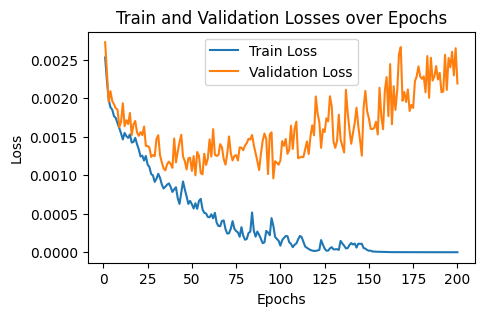

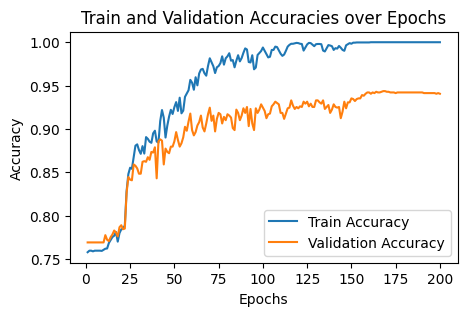

In [25]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [23]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/5000_LSTM_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 6/6 [00:00<00:00, 480.13it/s]

Best epoch: 168
macro F1 Score: 0.8904769807813588
AUROC: 0.9397331485011262
Accuracy: 0.9140030441400304


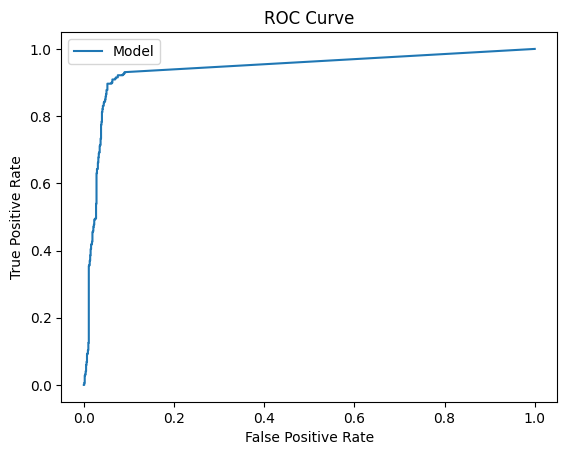

In [27]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)